**Create the enviroment, attack robot, defence robot and sword for path generation**

In [79]:
import robotic as ry
import time
import numpy as np
import os
import time
import matplotlib.pyplot as plt

# C = ry.Config()

# table = C.addFrame('table',parent='world') .setShape(ry.ST.ssBox,[4., 1., 0., .05]) .setPosition([0,0,0]).setColor([.2]).setContact(1)
# attacker = C.addFile(ry.raiPath('panda/panda.g')).setPosition([0.,2.,.5]).setQuaternion([1,0,0,1])
# defender = C.addFile(ry.raiPath('panda/panda.g'), 'r_').setPosition([1.5,2.,.5]).setQuaternion([1,0,0,1])

# attacker_base = [0,2,0.5]
# defender_base = [1.5,2,0.5]
# attacker.setParent(table)
# defender.setParent(table)

# attacker.setPosition([-0.5,0.,.05])
# defender.setQuaternion([0,0,0,1])
# defender.setPosition([0.5,0.,.05])

# joint_pos = C.getJointState()
# qhome = joint_pos.copy()
# qhome_attacker = qhome[:8]
# qhome_defender = qhome[8:]
# C.setJointState(joint_pos)

# C.addFrame('box',parent='gripper').setShape(ry.ST.ssBox,[0.1, .03, 0.03, 0.01]) .setRelativePosition([0,0,0]) .setColor([.9]).setRelativeQuaternion([1,0,0,1]).setContact(1)
# C.addFrame('box1',parent='box').setShape(ry.ST.ssBox,[0.4, .02, 0.02, 0]) .setRelativePosition([0.2,0,0]) .setColor([.9]).setContact(1)
# C.addFrame('box2',parent='box').setShape(ry.ST.ssBox,[0.04, .08, 0.05, 0]) .setRelativePosition([0.05,0,0]) .setColor([.9]).setContact(1)
# C.addFrame('box3',parent='box').setShape(ry.ST.ssBox,[0.04, .08, 0.05, 0]) .setRelativePosition([-0.05,0,0]) .setColor([.9]).setContact(1)
# C.addFrame('box4',parent='box').setShape(ry.ST.ssBox,[0.02, .02, 0.02, 0]) .setRelativePosition([0.3,0,0]) .setColor([.9])
# sword_tip = C.getFrame('box4')
# robot_base = C.getFrame('robot_base')


In [80]:
C = ry.Config()
C.addFile("/home/said/cs549/project/rai-robotModels/scenarios/pandasFightPathGeneration.g")
C.view()

print(C.getJointState().shape)
C.setJointState(np.array([ 0.  , -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.  ,  0.  ,
       -1.  ,  0.  , -2.  ,  0.  ,  2.  ,  0.]))


joint_pos = C.getJointState()
qhome = joint_pos.copy()
qhome_attacker = qhome[:7]
qhome_defender = qhome[7:]

C.addFrame('box4',parent='sword_0').setShape(ry.ST.ssBox,[0.02, .02, 0.02, 0]).setRelativePosition([0.35,0,0]).setColor([0,0,0,0])
sword_tip = C.getFrame('box4')

q0 = C.getJointState()
X0 = C.getFrameState()

C.view()

print(q0)

(14,)
[ 0. -1.  0. -2.  0.  2.  0.  0. -1.  0. -2.  0.  2.  0.]


In [3]:
C.getCollisions(0)

[]

**Define end effectors sword and shiled as variable**

In [4]:
defender_end_eff = C.frame('r_gripper')
attacker_end_eff = C.frame('l_gripper')
sword_tip = C.frame('box4')
print(f'defender end effector: {defender_end_eff.getPosition()}')
print(f'attacker end effector: {attacker_end_eff.getPosition()}')
print(f'sword tip: {sword_tip.getPosition()}')

defender end effector: [2.18103728e-01 3.59025877e-16 1.41037014e+00]
attacker end effector: [-2.18103728e-01  1.25455202e-16  1.41037014e+00]
sword tip: [-0.5   0.75  0.63]


**Define camera looking at defender for random attack patterns**

In [77]:
f1 = C.addFrame('camera1') .setShape(ry.ST.marker, [.1])
f1.setPose('t(-0.2 0. 1.3) d(-90 1 0 0) d(90 0 1 0)') 
f1.setAttribute('focalLength', .895) # wide angle
f1.setAttribute('width', 640)
f1.setAttribute('height', 360)

f2 = C.addFrame('camera2') .setShape(ry.ST.marker, [.1])
f2.setPose('t(0. -0.4 1.3) d(90 1 0 0) d(120 0 1 0)') 
f2.setAttribute('focalLength', .895) # wide angle
f2.setAttribute('width', 640)
f2.setAttribute('height', 360)

f3 = C.addFrame('camera3') .setShape(ry.ST.marker, [.1])
f3.setPose('t(0. 0.4 1.3) d(90 1 0 0) d(60 0 1 0) ') 
f3.setAttribute('focalLength', .895) # wide angle
f3.setAttribute('width', 640)
f3.setAttribute('height', 360)

cam1 = ry.CameraView(C)
cam2 = ry.CameraView(C)
cam3 = ry.CameraView(C)

cam1.setCamera('camera1')
cam2.setCamera('camera2')
cam3.setCamera('camera3')

#After setting random states to the defender robot run this function to find the surface points of the robot
def find_hittable_points(cam1,cam2,cam3,C,defence_joint_states):
    C.setJointState(defence_joint_states) 

    rgb1, depth1 = cam1.computeImageAndDepth(C)
    pcl1 = ry.depthImage2PointCloud(depth1, cam1.getFxycxy())
    rgb2, depth2 = cam2.computeImageAndDepth(C)
    pcl2 = ry.depthImage2PointCloud(depth2, cam2.getFxycxy())
    rgb3, depth3 = cam3.computeImageAndDepth(C)
    pcl3 = ry.depthImage2PointCloud(depth3, cam3.getFxycxy())


    inverse_rot1 = f1.getRotationMatrix().T
    cam1_pos = f1.getPosition()
    transformed_pcl1 = np.dot(pcl1.reshape(-1, 3), inverse_rot1) + cam1_pos
    transformed_pcl1 = transformed_pcl1.reshape(pcl1.shape)

    inverse_rot2 = f2.getRotationMatrix().T
    cam2_pos = f2.getPosition()
    transformed_pcl2 = np.dot(pcl2.reshape(-1, 3), inverse_rot2) + cam2_pos
    transformed_pcl2 = transformed_pcl2.reshape(pcl2.shape)

    inverse_rot3 = f3.getRotationMatrix().T
    cam3_pos = f3.getPosition()
    transformed_pcl3 = np.dot(pcl3.reshape(-1, 3), inverse_rot3) + cam3_pos
    transformed_pcl3 = transformed_pcl3.reshape(pcl3.shape)

    transformed_pcl = np.concat([transformed_pcl1, transformed_pcl2, transformed_pcl3])  

    zmin  = 0.9
    mask = (transformed_pcl[..., 2] >= zmin)

    # Filtered array contains all the hitable points
    filtered_array = transformed_pcl[mask]
    filtered_array = filtered_array[~np.all(filtered_array == [0,0.4,0.6], axis=1)]
    filtered_array = filtered_array[~np.all(filtered_array == [0,-0.4,0.6], axis=1)]
    
    filtered_array = filtered_array[~np.all(filtered_array == [-0.2 ,0., 0.6], axis=1)]

    plt.imshow(rgb1)
    plt.show()
    plt.imshow(rgb2)
    plt.show()
    plt.imshow(rgb3)
    plt.show()
    # f = C.addFrame('pcl', 'world')
    # f.setPointCloud(filtered_array, [255,0,0])
    # C.view(False)
    return filtered_array

#filtered_array = find_hittable_points(cam1,cam2,cam3,C,qhome)
# # Visualize the point cloud
# f = C.addFrame('pcl', 'world')
# f.setPointCloud(filtered_array, [255,0,0])
# C.view(False)

-- WARNING:kin.cpp:addFrame:193(-1) frame already exists! returning existing without modifications!
-- WARNING:kin.cpp:addFrame:193(-1) frame already exists! returning existing without modifications!
-- WARNING:kin.cpp:addFrame:193(-1) frame already exists! returning existing without modifications!


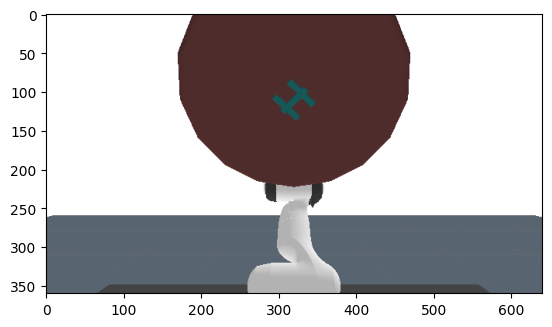

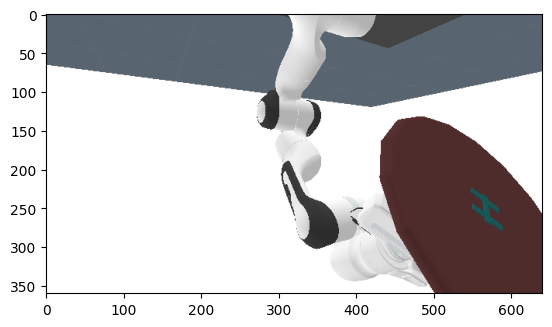

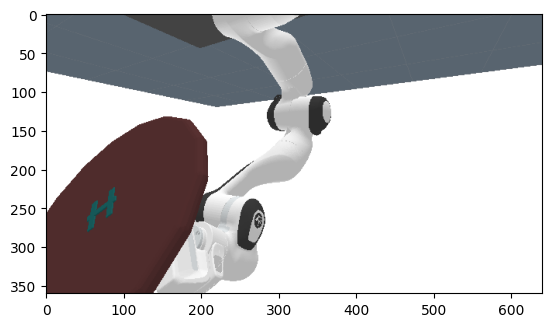

array([[-0.2,  0. ,  1.3],
       [-0.2,  0. ,  1.3],
       [-0.2,  0. ,  1.3],
       ...,
       [ 0. ,  0.4,  1.3],
       [ 0. ,  0.4,  1.3],
       [ 0. ,  0.4,  1.3]])

In [78]:
find_hittable_points(cam1,cam2,cam3,C,qhome)

In [6]:
# This function is implemented because pcl returns immense number of hitting points this function reduces it
def select_hitting_points(surface_points,sword_tip,defender_end_eff):
    
    defender_end_eff_pos = defender_end_eff.getPosition()
    sword_tip_pos = sword_tip.getPosition()
    
    distances_defender = np.linalg.norm(surface_points - defender_end_eff_pos,axis = 1)
    distances_sword = np.linalg.norm(surface_points - sword_tip_pos,axis = 1)

    distance_sum = 0.55*distances_defender - distances_sword*0.45 + 0.2*surface_points[:,2]

    max_index = np.argmax(distance_sum)
    surface_points = surface_points[max_index,:]
    
    if len(surface_points) > 0:
        return surface_points
    else:
        return None

In [7]:
#This function finds the attack path for the robot

def create_attack_path(C,robot_positions,hitting_point):
    
    target = C.addFrame('target', 'world')
    target.setShape(ry.ST.marker, [0.1])
    target.setPosition(hitting_point)

    C.setJointState(robot_positions)
    
    komo = ry.KOMO(C, 1, 10, 2, True)
    komo.addControlObjective([], 2, 1e1)
    #komo.addControlObjective([], 1, 1e1)

    # komo.addObjective([0.,1.], ry.FS.jointState, [], ry.OT.eq, [1e1], [], order=1)
    komo.addObjective([1.], ry.FS.positionDiff, ['box4', 'target'], ry.OT.eq, [1e2])
    komo.addObjective([0.,0.95], ry.FS.accumulatedCollisions, [], ry.OT.eq,[1e1])

    ret = ry.NLP_Solver() \
        .setProblem(komo.nlp()) \
        .setOptions( stopTolerance=1e-2) \
        .solve()

    path = komo.getPath()
    C.delFrame('target')
    return path

In [66]:
ctrl_stop = False
k = 0
j = 0
while ctrl_stop == False:

    random_joint_states = q0+np.random.uniform(-1,1,14)*0.2*np.pi
    defence_joint_states = np.concatenate([qhome_attacker,random_joint_states[7:]]).flatten()

    sword_tip_offset = np.random.rand()*0.1 + 0.3
    C.getFrame('box4').setRelativePosition([sword_tip_offset,0,0])
    
    attacker_base = sword_tip.getPosition()
    defence_robot_surface_points = find_hittable_points(cam1,cam2,cam3,C,defence_joint_states)
    defence_robot_surface_points = select_hitting_points(defence_robot_surface_points,sword_tip,defender_end_eff)   #extract hitting points

    C.setJointState(random_joint_states)    #move the attacker robot to random joint states
    collusion_number = C.getCollisions(0)
    if len(collusion_number) == 0:

        if defence_robot_surface_points is not None:

            k = 0
            path = create_attack_path(C,random_joint_states,defence_robot_surface_points)

            attacker_path = path[:,:7]
            attacker_init = random_joint_states[:7].reshape(1,-1)
            defender_init = random_joint_states[7:].reshape(1,-1)

            init_added_attacker_path = np.concatenate([attacker_init,attacker_path],axis = 0)
            init_added_defender_path = np.repeat(defender_init,init_added_attacker_path.shape[0],axis=0)

            init_added_path = np.concatenate([init_added_attacker_path,init_added_defender_path],axis = 1)
            np.save(f'./attackPaths/path_case{j}_{k}.npy',init_added_path)
            k+=1
                
            if j %5 == 4:
                print(f'{j}`th case is created')
            j+=1

    if j == 30:
        ctrl_stop = True

-- WARNING:kin.cpp:getFrame:412(-1) cannot find frame named 'box4'


AttributeError: 'NoneType' object has no attribute 'setRelativePosition'

In [8]:
path = np.load('attackPaths/path_case9_0.npy')
print(path.shape)
# bot = ry.BotOp(C, useRealRobot=False)
# bot.moveTo(path[0])
# time.sleep(5)
i = 0
for states in path:
    C.setJointState(states)
    print(f'{i}th state')
    i+=1
    C.view()
    time.sleep(0.4)


(11, 14)
0th state
1th state
2th state
3th state
4th state
5th state
6th state
7th state
8th state
9th state
10th state


In [36]:
path = np.load('attackPaths/path_case5_0.npy')
C.setJointState(q0)
C.view()

110

In [4]:
import scipy
def interpolate_path(path,N):
    cubic_spline_interpolator = scipy.interpolate.CubicSpline(np.arange(path.shape[0]), path, axis = 0) 
    interp_path = cubic_spline_interpolator(np.linspace(0,path.shape[0]-1,N))

    return interp_path

# Take sword and sheld

In [5]:
komo = ry.KOMO(C, 10, 10, 2, True)
komo.addControlObjective([], 0, 1e-1) 
komo.addControlObjective([], 2, 1e0)
komo.addObjective([], ry.FS.accumulatedCollisions, [], ry.OT.eq,[1e1])
komo.addObjective([5,10], ry.FS.positionDiff, ['r_gripper', "shi-h1"], ry.OT.eq, [1e1])
komo.addObjective([5.,10.], ry.FS.scalarProductZZ, ['r_gripper', 'shi-h1'], ry.OT.eq, [1e1], [])
komo.addObjective([5.,10.], ry.FS.scalarProductXZ, ['shi-h1','r_gripper'], ry.OT.eq, [1e1], [])
komo.addObjective([5.,10.], ry.FS.scalarProductXZ, ['r_gripper','shi-h1'], ry.OT.eq, [1e1], [])

# komo.addObjective([3,5], ry.FS.position,['l_gripper'], ry.OT.eq, [1e1], grasp_pos + np.array([0, 0, 0.5]) )

# komo.addObjective([5,10], ry.FS.position,['l_gripper'], ry.OT.eq, [1e1], grasp_pos )
# komo.addObjective([5,10], ry.FS.vectorX, ['l_gripper'], ry.OT.eq, [1e1],normal)

ret = ry.NLP_Solver() \
.setProblem(komo.nlp()) \
.setOptions( stopTolerance=1e-2, verbose=4 ) \
.solve()

take_shield = komo.getPath()

====nlp==== method:AugmentedLagrangian bounded: yes
==nlp== it:0 evals:0 mu:1 nu:1 muLB:0.1
----newton---- initial point f(x):12133.5 alpha:1 beta:1
--newton-- it:   1  |Delta|:        0.2  alpha:          1  evals:   2  f(y):     9427.2  ACCEPT
--newton-- it:   2  |Delta|:        0.2  alpha:          1  evals:   3  f(y):    7039.78  ACCEPT
--newton-- it:   3  |Delta|:        0.2  alpha:          1  evals:   4  f(y):    5080.29  ACCEPT
--newton-- it:   4  |Delta|:        0.2  alpha:          1  evals:   5  f(y):    3548.65  ACCEPT
--newton-- it:   5  |Delta|:        0.2  alpha:          1  evals:   6  f(y):    2467.87  ACCEPT
--newton-- it:   6  |Delta|:        0.2  alpha:          1  evals:   7  f(y):    1637.22  ACCEPT
--newton-- it:   7  |Delta|:        0.2  alpha:          1  evals:   8  f(y):    980.115  ACCEPT
--newton-- it:   8  |Delta|:        0.2  alpha:          1  evals:   9  f(y):    482.727  ACCEPT
--newton-- it:   9  |Delta|:        0.2  alpha:          1  evals:  10  f(y

In [12]:
C.setJointState(take_shield[-1])
C.view()

0

In [6]:
komo = ry.KOMO(C, 10, 10, 2, True)
komo.addControlObjective([], 0, 1e-1) 
komo.addControlObjective([], 2, 1e0)
komo.addObjective([], ry.FS.accumulatedCollisions, [], ry.OT.eq,[1e1])
komo.addObjective([5,10], ry.FS.positionDiff, ['l_gripper', "sword_0"], ry.OT.eq, [1e1])
komo.addObjective([5.,10.], ry.FS.scalarProductYZ, ['sword_0','l_gripper'], ry.OT.eq, [1e1], [])
komo.addObjective([5.,10.], ry.FS.scalarProductXZ, ['sword_0','l_gripper'], ry.OT.eq, [1e1], [])
komo.addObjective([5.,10.], ry.FS.scalarProductXX, ['l_gripper','sword_0'], ry.OT.eq, [1e1], [])

# komo.addObjective([3,5], ry.FS.position,['l_gripper'], ry.OT.eq, [1e1], grasp_pos + np.array([0, 0, 0.5]) )

# komo.addObjective([5,10], ry.FS.position,['l_gripper'], ry.OT.eq, [1e1], grasp_pos )
# komo.addObjective([5,10], ry.FS.vectorX, ['l_gripper'], ry.OT.eq, [1e1],normal)

ret = ry.NLP_Solver() \
.setProblem(komo.nlp()) \
.setOptions( stopTolerance=1e-2, verbose=4 ) \
.solve()

take_sword= komo.getPath()

====nlp==== method:AugmentedLagrangian bounded: yes
==nlp== it:0 evals:0 mu:1 nu:1 muLB:0.1
----newton---- initial point f(x):11392 alpha:1 beta:1
--newton-- it:   1  |Delta|:        0.2  alpha:          1  evals:   2  f(y):    8811.41  ACCEPT
--newton-- it:   2  |Delta|:        0.2  alpha:          1  evals:   3  f(y):    6700.83  ACCEPT
--newton-- it:   3  |Delta|:        0.2  alpha:          1  evals:   4  f(y):    4841.77  ACCEPT
--newton-- it:   4  |Delta|:        0.2  alpha:          1  evals:   5  f(y):    3200.89  ACCEPT
--newton-- it:   5  |Delta|:        0.2  alpha:          1  evals:   6  f(y):    2093.78  ACCEPT
--newton-- it:   6  |Delta|:        0.2  alpha:          1  evals:   7  f(y):    1364.68  ACCEPT
--newton-- it:   7  |Delta|:        0.2  alpha:          1  evals:   8  f(y):    851.123  ACCEPT
--newton-- it:   8  |Delta|:        0.2  alpha:          1  evals:   9  f(y):    459.243  ACCEPT
--newton-- it:   9  |Delta|:        0.2  alpha:          1  evals:  10  f(y):

In [14]:
C.setJointState(take_sword[-1])
C.view()

0

In [7]:
armed=np.concatenate([take_sword[-1,0:7], take_shield[-1,7:]])

In [16]:
C.setJointState(armed)
C.view()

0

# Start Simulation from path[0,:]

In [47]:
del C

In [84]:
C = ry.Config()
C.addFile("/home/said/cs549/project/rai-robotModels/scenarios/pandasFight.g")
C.view()

0

In [85]:
C.setJointState(qhome)
C.view()

0

In [86]:
# C.setJointState(path[0,:])
S = ry.Simulation(C, ry.SimulationEngine.physx, verbose=0)
C.view()

0

# Simulation Functions

In [ ]:
C.view()
def simulationCloseGrippers(S, tau=0.01):
    S.closeGripper('l_gripper', width=0.0001, speed=0.5)
    while (not S.getGripperIsGrasping('l_gripper')) and (S.getGripperWidth('l_gripper') > 0.001):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()
    
    S.closeGripper('r_gripper', width=0.0001, speed=0.5)
    while (not S.getGripperIsGrasping('r_gripper')) and (S.getGripperWidth('r_gripper') > 0.001):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()


def simulationOpenGrippers(S, tau=0.01):
    S.openGripper('l_gripper', width=0.05, speed=0.5)
    while S.getGripperWidth('l_gripper') < 0.05 - 0.01:
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()
    S.openGripper('r_gripper', width=0.05, speed=0.5)
    while S.getGripperWidth('r_gripper') < 0.05 - 0.01:
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()

def simulationGoTo(S, q, tau=0.01, checkCol=False):
    checkColTime = 0.1
    timer = 0
    while np.linalg.norm(S.get_q() - q) > 0.01:
        time.sleep(tau)
        S.step(q, tau, ry.ControlMode.position)
        timer += tau
        C.view()
        if timer > 4:
            print("Target cannot be reached within 4 seconds.")
            break
        if checkCol:
            if timer > checkColTime:
                if findCollision(C, 'sword_1'):
                    return
                else:
                    checkColTime += 0.1

def simulationGoHome(S, tau=0.01):
    checkColTime = 0.1
    timer = 0
    while np.linalg.norm(S.get_q() - q0) > 0.01:
        time.sleep(tau)
        S.step(q0, tau, ry.ControlMode.position)
        C.view()
        timer += tau
        # if timer > checkColTime:
        #     if findCollision(C, 'sword_1'):
        #         break
        #     else:
        #         checkColTime += 0.1
            
def simulationFollowPath(S, path, tau=0.01):
    checkColTime = 0.1
    timer = 0
    for i in range(len(path)):
        while np.linalg.norm(S.get_q() - path[i]) > 0.3:
            time.sleep(tau)
            print(i)
            print(np.linalg.norm(S.get_q() - path[i]))
            S.step(path[i], tau, ry.ControlMode.position)
            C.view()
            timer += tau
            if timer > checkColTime:
                print('check_col')
                if findCollision(C, 'sword_1'):
                    return
                else:
                    checkColTime += 0.1

    simulationGoTo(S, path[-1], checkCol=True)

def simulationWait(S, t, tau=0.01):
    for k in range(int(t / tau)):
        time.sleep(tau)
        S.step([], tau, ry.ControlMode.none)
        C.view()

def simulationTorqueCtrl(S, t, torque, tau=0.01):
    for k in range(int(t / tau)):
        time.sleep(tau)
        S.step(torque, tau, ry.ControlMode.acceleration)
        C.view()

def simulationVelocityCtrl(S,t,vel,tau=0.01):
    for k in range(int(t/tau)):
        time.sleep(tau)
        S.step(vel,tau,ry.ControlMode.velocity)
        C.view()

def followInterpolatedPath(S,path,tau=0.01):
    checkColTime = 0.1
    timer = 0
    for i in range(len(path)):
        time.sleep(tau)
        print(i)
        print(np.linalg.norm(S.get_q()- path[i]))
        S.step(path[i],tau,ry.ControlMode.position)
        C.view()
        timer += tau
        if timer > checkColTime:
            if findCollision(C,'sword_1'):
                return
            else:
                checkColTime += 0.1
    simulationGoTo(S,path[-1],checkCol=True)

def findCollision(C,object1):
    collisions = [col for col in C.getCollisions(0) if object1 in col and not col[1].startswith('l_') and not col[0].startswith('l_')]
    if len(collisions) > 0:
        print('sword collided with something')
        return True
    else:
        return False
    
# Use this code. It is awesome. It will follow the path and stop if there is a collision.    
def followSplinePath(S,path,t,tau=0.01):
    """
        Guides a simulation object along a specified spline path.
        Parameters:
        S (Simulation): The simulation object that will follow the path.
        path (array): A list of waypoints defining the spline path.
        t (float): The total time duration for following the path.
        tau (float, optional): The time step for each simulation step. Default is 0.01.
        The function performs the following steps:
        1. Resets the spline reference of the simulation object.
        2. Sets the spline reference with the given path and a time vector.
        3. Iteratively steps through the simulation, updating the view and checking for collisions.
        4. If a collision with 'sword_1' is detected, the function exits early.
        5. The loop runs for a duration slightly longer than `t` to ensure completion.
        Note:
        - The `+20` in the loop range is a heuristic to prevent early termination when `t` is low.
        - The function checks for collisions every 0.1 seconds.

    """
    checkColTime = 0.1
    timer = 0
    S.resetSplineRef() # Reset previous spline reference
    S.setSplineRef(path,np.linspace(0.01,t,len(path))) # Set new spline reference
    for k in range(int(t/tau)+20): # This +20 is heuristic. It was stopping after a short time when t was low.
        time.sleep(tau)
        S.step([],tau,ry.ControlMode.spline)
        C.view()
        timer += tau
        if timer > checkColTime: # Check for collisions every 0.1 seconds
            if findCollision(C,'sword_1'): # Check if sword is colliding with something (left robot is excluded (no self collision))
                return
            else:
                checkColTime += 0.1 # Increment the collision check time
    #simulationGoTo(S,path[-1],checkCol=True)


In [89]:
simulationGoTo(S,armed)

In [90]:
simulationCloseGrippers(S)

-- kin_physx.cpp:addJoint:298(0) ADDING JOINT l_panda_joint7-sword_0 of type rigid with rel [0, 0, 0]
-- kin_physx.cpp:addJoint:298(0) ADDING JOINT r_panda_joint7-shi of type rigid with rel [0, 0, 0]


In [ ]:
simulationGoHome(S)

In [32]:
torques = np.zeros(14)
torques[13]=100000
simulationTorqueCtrl(S,1,torques)

In [168]:
S.resetSplineRef()
S.setSplineRef(path,np.linspace(0.01,1.01,len(path)))

In [169]:
for k in range(100):
    S.step([],0.01,ry.ControlMode.spline)
    time.sleep(0.01)
    C.view()

In [202]:
simulationGoTo(S,path[0])

#simulationGoTo(S,path[-1])

In [201]:
followSplinePath(S,path,0.1)

sword collided with something


In [148]:
simulationFollowPath(S,path,0.1)

3
0.4037204212506637
check_col
4
0.43925112966681534
check_col
5
0.49590571375867676
check_col
6
0.5596757144329019
check_col
7
0.6197308777309872
check_col
8
0.6717756083367519
check_col
8
0.31555450349408337
check_col
9
0.534835109296396
check_col
sword collided with something


In [136]:
[col for col in C.getCollisions(0) if 'sword_3' in col and not col[1].startswith('l_') and not col[0].startswith('l_')]

[]

In [109]:
followInterpolatedPath(S,interpolate_path(path,1000),0.001)

0
0.009982472553704724
1
0.009538967611643141
2
0.009094184976318184
3
0.008649421233470343
4
0.008205916121531126
5
0.007765029714752111
6
0.007328574464616353
7
0.006898532344746591
8
0.006477227855346468
9
0.0060675542996326565
10
0.005672981584883743
11
0.005297774340700245
12
0.00494748144015187
13
0.004628941011817344
14
0.004349783086371924
15
0.004119230468249483
16
0.00394692051277437
17
0.0038418277836689326
18
0.003810406112784772
19
0.003855442390891417
20
0.003975343926253986
21
0.00416455553723211
22
0.004414876514770541
23
0.00471740482882229
24
0.005063389703562673
25
0.005445213484144418
26
0.0058564603874460205
27
0.0062918214709497405
28
0.0067472308407712156
29
0.0072191522554132
30
0.0077049972011691975
31
0.008202609596461302
32
0.008710415571233704
33
0.00922692409566049
34
0.009751112263856937
35
0.010282043984320966
36
0.010818958717463042
37
0.011361141194676487
38
0.01190822012214151
39
0.012459677124340015
40
0.013015313517153312
41
0.013574581683274137
42
0

KeyboardInterrupt: 

[('r_palm', 'l_panda_coll7', -0.06210522440681772),
 ('r_palm', 'l_panda_coll6', -0.016374270533267385),
 ('r_palm', 'l_panda_coll5', -0.022997770849173593)]

In [27]:
simulationFollowPath(S,path)

2
0.11657275782287736
2
0.10786921056879652
3
0.21272915492611036
3
0.19531289859872877
3
0.17823127470824993
3
0.16235899097523557
3
0.14776785617751972
3
0.1343991833821205
3
0.12217375932442684
3
0.11101063870632835
3
0.10083122529685391
4
0.23362603192453074
4
0.21421236971672408
4
0.19524977963447365
4
0.17772650590275413
4
0.16168856091224362
4
0.14704312820583443
4
0.13368306771042704
4
0.12150544108690331
4
0.11041437619112618
4
0.10032078956259718
5
0.2566108406123308
5
0.23529267504119641
5
0.2144647365721481
5
0.19526016218507322
5
0.1777076222741552
5
0.16169039310030847
5
0.14708120268107397
5
0.13376161865983915
5
0.12162394693580289
5
0.11056974833921882
5
0.10050906359203783
6
0.27575194953371446
6
0.2528812767491276
6
0.2305205322087986
6
0.20992565391768242
6
0.191110544397937
6
0.17394271030496142
6
0.15828160120314483
6
0.1439975968323829
6
0.13097395983465704
6
0.11910491729573505
6
0.10829457222801833
7
0.297844638080464
7
0.27320624989866393
7
0.24911895450001983

In [143]:
simulationOpenGrippers(S)

-- kin_physx.cpp:removeJoint:891(0) REMOVING JOINT 0x409cc00-0x5bb68f0 of type rigid
-- kin_physx.cpp:removeJoint:891(0) REMOVING JOINT 0x6a57db0-0x55d93a0 of type rigid


In [80]:
S.get_q()-path[5]

array([-6.13900565e-07, -8.73796530e-07,  5.14596067e-07, -4.36949859e-06,
       -5.54146634e-07, -4.80173561e-06, -3.04716573e-07, -3.67919279e-07,
        3.07995846e-07, -5.44952290e-07, -1.19858613e-06, -2.90774028e-07,
       -7.18512246e-07, -4.09328445e-08])

In [65]:
C.setJointState(q0)
C.view()

37

In [43]:
C.setJointState(path[3])
C.view()

37

In [41]:
C.setJointState(q_weird)
C.view()

37

In [22]:
simulationGoHome(S)

In [166]:
simulationFollowPath(S,path)

In [113]:
S.setState(X0)

STACK9 /home/said/robotics/bin/python() [0x42f078]
STACK8 /home/said/robotics/bin/python() [0x515ce9]
STACK7 /home/said/robotics/bin/python() [0x52c539]
STACK6 /home/said/robotics/bin/python(_PyObject_MakeTpCall
STACK5 /home/said/robotics/bin/python() [0x52e36b]
STACK4 /home/said/.local/lib/python3.9/site-packages/robotic/_robotic.so(+0x3a6b5) [0x73a53cd436b5]
STACK3 /home/said/.local/lib/python3.9/site-packages/robotic/_robotic.so(+0xa1f24) [0x73a53cdaaf24]
STACK2 rai::Simulation::setState(rai::ArrayDouble const&, rai::ArrayDouble const&, rai::ArrayDouble const&, rai::ArrayDouble const&)
STACK1 rai::Configuration::setFrameState(rai::ArrayDouble const&, rai::Array<rai::Frame*> const&)
STACK0 rai::LogToken::~LogToken()


== ERROR:kin.cpp:setFrameState:714(-2) CHECK_GE failed: 'X.d0'=129 'F.N'=132 -- X.d0=129 not equal to frames.N=132


RuntimeError: kin.cpp:setFrameState:714(-2) CHECK_GE failed: 'X.d0'=129 'F.N'=132 -- X.d0=129 not equal to frames.N=132

In [14]:
def move_a_bit(path):
    tau = .01
    pathx = []
    pathI = interpolate_path(path[1:,:],100)
    for i in range(len(pathI)):
        q = pathI[i]
        S.step(q, tau,  ry.ControlMode.position)
        print(S.getTimeToMove())
    print(len(pathx))

In [ ]:
tau = .003
pathI = interpolate_path(path[1:,:],100)
bot.moveTo(path[1])
for i in range(len(pathI)):
    bot.moveTo(pathI[i],timeCost=100)

In [37]:
len(path)

11

In [17]:
S = ry.Simulation(C, ry.SimulationEngine.physx, verbose=0)
move_a_bit(path)

NameError: name 'path' is not defined

In [148]:
del bot

In [113]:
len(path)

21

In [ ]:
% Frequency and Gain Data
freq_kHz = [30, 60, 120, 240, 300, 360, 600, 1200, ...
            2800, 5600, 7000, 8400, 14000, 28000, 56000]; % in kHz
gain_dB = [-0.1, -0.2, -0.2, -2.85, -3.45, -4.5, -7.13, -12.4, ...
           -18, -22, -22.5, -24.5, -25, -25, -25]; % in dB

% Convert frequency to Hz for semilog plot
freq_Hz = freq_kHz * 1e3;

% Plot the data
figure;
semilogx(freq_Hz, gain_dB, '-o', 'LineWidth', 1.5, 'MarkerSize', 6);
grid on;
title('Frequency Response (dB Gain)');
xlabel('Frequency (Hz)');
ylabel('Gain (dB)');
xlim([1e4, 1e8]); % Adjust based on the frequency range
ylim([-30, 0]); % Adjust based on the dB range